In [1]:
%load_ext autoreload 
%autoreload 2

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import transformers.optimization as trans_optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import numpy as np 
import matplotlib.pyplot as plt 
import data
import gpt 
from tqdm import tqdm, trange
import json 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
if device == 'cuda': 
  print(torch.cuda.get_device_name()) 
else: 
  print(device) 

with open('config.json', 'r') as file: 
  config = json.load(file)

lr = config['lr']
bs = config['batch_size']

vocab_size, encode = data._init_data() # total: 4,236,416 characters

NVIDIA GeForce RTX 3090


In [2]:
model = gpt.gpt_model(vocab_size=vocab_size).to(device) 
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters.')

58.395801 M parameters.


In [3]:
def clamp_adaptive_span(): 
  for i in model.blocks: 
    for j in i.sa.heads: 
      j.adaptive_span.clamp_param()

In [4]:
optimizer = optim.AdamW(model.parameters(), lr=lr)
# optimizer = trans_optim.Adafactor(model.parameters(), lr=lr, relative_step=False)
# scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=1e-9, total_iters=16000)

losses, val_losses, val_loss, best_val_loss, best_val_iter = list(), list(), 0, 100, 0
scaler = torch.cuda.amp.GradScaler() 

steps = 64 // bs 
print(f'Steps: {steps}')

max_iters = 62500 #62.5k iterations for train, and 3k for test is the ideal number. 
print(data.dataloader('train')[0].shape)
for iter in (loop := trange(max_iters)): 
	x, y = data.dataloader('train')
	logits = model(x.to(device))

	B, T, C = logits.shape 
	logits = logits.view(B*T, C)
	targets = y.view(B*T)
	loss = F.cross_entropy(logits, targets.to(device)) / steps
	losses.append(loss.item()*steps)
	loss.backward()
	if iter % steps == 0: 
		# nn.utils.clip_grad_value_(model.parameters(), 0.03)
		optimizer.step() 
		clamp_adaptive_span()
		model.zero_grad()
		# scheduler.step()

	if iter % 128 == 0: 
		loss_dim = 40
		val_loss_tensor = torch.zeros((loss_dim))
		for j in range(loss_dim): 
			x, y = data.dataloader('val')
			with torch.no_grad(): 
				logits = model(x.to(device))

				B, T, C = logits.shape 
				logits = logits.view(B*T, C)
				targets = y.view(B*T)
				val_loss = F.cross_entropy(logits, targets.to(device)) 
			val_loss_tensor[j] = val_loss.item()
		val_losses.append(val_loss_tensor.mean().item())
		if val_losses[-1] < best_val_loss: 
			best_val_loss = val_losses[-1]
			best_val_iter = iter
			torch.save(model.state_dict(), f'models/adaptive_span_final_2048_8_heads_8_layers.pth')

	loop.set_description(f'Iterations: {iter+1}/{max_iters}')
	loop.set_postfix(loss=loss.item()*steps, val_loss=val_losses[-1], best_val_loss=best_val_loss, best_iter=best_val_iter)#, z_lr=scheduler.get_last_lr()[0])

plt.plot(losses)
plt.show()
plt.plot(val_losses) # 

Steps: 16
torch.Size([4, 2048])


Iterations: 50626/62500:  81%|████████  | 50626/62500 [9:18:10<2:10:54,  1.51it/s, best_iter=39168, best_val_loss=0.927, loss=0.668, val_loss=0.99]  


KeyboardInterrupt: 

In [ ]:
model = gpt.gpt_model(vocab_size=vocab_size, enable_adaptive_span=False).to(device) 
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters.')

57.216089 M parameters.


Steps: 2


Iterations: 6200/6200: 100%|██████████| 6200/6200 [1:13:43<00:00,  1.40it/s, best_iter=5760, best_val_loss=0.95, loss=0.841, val_loss=0.953]   

torch.Size([32, 512])


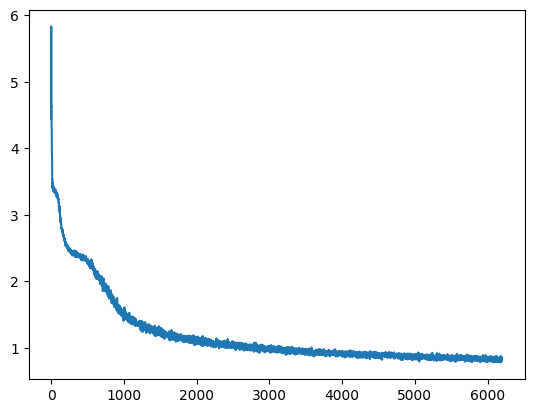

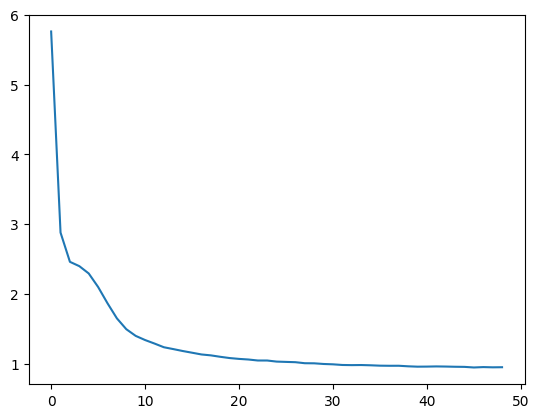

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

losses, val_losses, val_loss, best_val_loss, best_val_iter = list(), list(), 0, 100, 0
scaler = torch.cuda.amp.GradScaler() 

steps = 64 // bs 
print(f'Steps: {steps}')

max_iters = 6200
for iter in (loop := trange(max_iters)): 
	x, y = data.dataloader('train')
	
	logits = model(x.to(device))

	B, T, C = logits.shape 
	logits = logits.view(B*T, C)
	targets = y.view(B*T)
	loss = F.cross_entropy(logits, targets.to(device)) / steps
	losses.append(loss.item()*steps)
	loss.backward()
	if iter % steps == 0: 
		optimizer.step() 
		model.zero_grad()

	if iter % 128 == 0: 
		loss_dim = 40*steps
		val_loss_tensor = torch.zeros((loss_dim))
		for j in range(loss_dim): 
			x, y = data.dataloader('val')
			with torch.no_grad(): 
				logits = model(x.to(device))

				B, T, C = logits.shape 
				logits = logits.view(B*T, C)
				targets = y.view(B*T)
				val_loss = F.cross_entropy(logits, targets.to(device)) 
			val_loss_tensor[j] = val_loss.item()
		val_losses.append(val_loss_tensor.mean().item())
		if val_losses[-1] < best_val_loss: 
			best_val_loss = val_losses[-1]
			best_val_iter = iter

	loop.set_description(f'Iterations: {iter+1}/{max_iters}')
	loop.set_postfix(loss=loss.item()*steps, val_loss=val_losses[-1], best_val_loss=best_val_loss, best_iter=best_val_iter)

# torch.save(model.state_dict(), f'models/no_adaptive_span_final_23k.pth')

print(x.shape)
plt.plot(losses)
plt.show()
plt.plot(val_losses)